In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

In [ ]:
file_path = "/content/Maternal Health and High-Risk Pregnancy.xlsx"
df = pd.read_excel(file_path, header=1)

df.columns = [
    'Name', 'Age', 'Gravida', 'TT_Vaccine', 'Gestational_Period', 'Weight',
    'Height', 'Blood_Pressure', 'Anemia', 'Jaundice', 'Fetal_Position',
    'Fetal_Movement', 'Fetal_Heartbeat', 'Urine_Albumin', 'Urine_Sugar',
    'VDRL', 'HBsAG', 'Risk_Level'
]
print("Shape:", df.shape)
display(df.head(5))
display(df.columns.tolist())

Shape: (998, 18)


,Name,Age,Gravida,TT_Vaccine,Gestational_Period,Weight,Height,Blood_Pressure,Anemia,Jaundice,Fetal_Position,Fetal_Movement,Fetal_Heartbeat,Urine_Albumin,Urine_Sugar,VDRL,HBsAG,Risk_Level
0,Rituporna,18,1st,1st,38 week,50 kg,5.3'',100/60,NaN,NaN,Normal,Normal,140m,NaN,Yes,Negative,Negative,Yes
1,Moina,25,2nd,2nd,38 week,60 kg,5.2'',100/70,NaN,NaN,Normal,Normal,130m,NaN,Yes,Positive,Negative,No
2,Rabeya,20,1st,1st,30 week,55 kg,5.0'',100/60,NaN,NaN,Normal,Normal,120m,NaN,Yes,Negative,Negative,Yes
3,Shorna,22,1st,3rd,35 week,51 kg,5.4'',110/65,NaN,NaN,Normal,Normal,130m,NaN,Yes,Positive,Negative,Yes
4,Tania Akter,20,1st,2nd,30 week,53 kg,5.2'',100/55,NaN,NaN,Normal,Normal,125m,NaN,Yes,Negative,Negative,No


['Name',
 'Age',
 'Gravida',
 'TT_Vaccine',
 'Gestational_Period',
 'Weight',
 'Height',
 'Blood_Pressure',
 'Anemia',
 'Jaundice',
 'Fetal_Position',
 'Fetal_Movement',
 'Fetal_Heartbeat',
 'Urine_Albumin',
 'Urine_Sugar',
 'VDRL',
 'HBsAG',
 'Risk_Level']

In [ ]:
df = df.dropna(how='all')  # Drop completely empty rows
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])  # Mode for categorical
    else:
        df[col] = df[col].fillna(df[col].median())  # Median for numerical

df = df.drop_duplicates()

In [ ]:
X = df.drop("Risk_Level", axis=1)
y = df["Risk_Level"]


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
y = label_enc.fit_transform(y)


In [ ]:
label_enc = LabelEncoder()
y = label_enc.fit_transform(y)
joblib.dump(label_enc, "label_encoder.joblib")

# Remove 'Name'
if "Name" in X.columns:
    X = X.drop("Name", axis=1)

# Columns
categorical_cols = X.select_dtypes(include="object").columns.tolist()
numerical_cols  = X.select_dtypes(include="number").columns.tolist()

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("num", StandardScaler(), numerical_cols)
])

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        tree_method="hist"   # CPU safe
    ))
])

model.fit(X, y)
joblib.dump(model, "model.joblib")


['model.joblib']

In [ ]:
!ls -lh model.joblib
!ls -lh label_encoder.joblib


-rw-r--r-- 1 root root 253K Nov 18 06:34 model.joblib
-rw-r--r-- 1 root root 343 Nov 18 06:34 label_encoder.joblib


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

models = {
    "Logistic Regression": Pipeline(steps=[
        ('preprocess', preprocessor),
        ('classifier', LogisticRegression(max_iter=500))
    ]),
    "Random Forest": Pipeline(steps=[
        ('preprocess', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
    ]),
    "XGBoost": Pipeline(steps=[
        ('preprocess', preprocessor),
        ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ])
}


Logistic Regression:
Test Accuracy: 0.930
Cross-Val Accuracy: 0.935
ROC AUC: 0.921
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        67
           1       0.95      0.95      0.95       133

    accuracy                           0.93       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.93      0.93      0.93       200



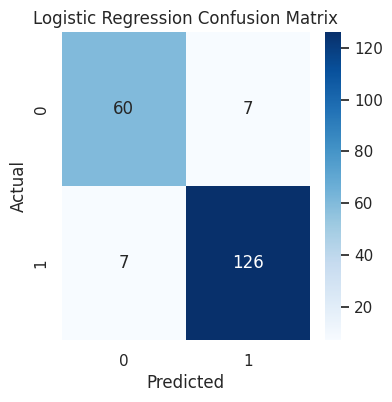


Random Forest:
Test Accuracy: 0.980
Cross-Val Accuracy: 0.972
ROC AUC: 0.978
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        67
           1       0.98      0.98      0.98       133

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



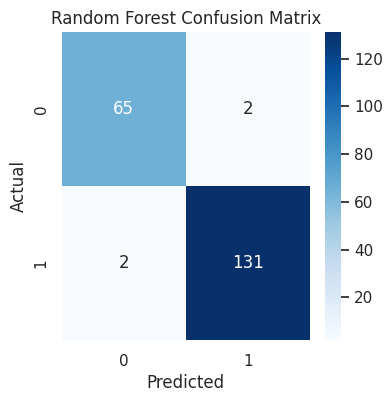


XGBoost:
Test Accuracy: 0.960
Cross-Val Accuracy: 0.969
ROC AUC: 0.955
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        67
           1       0.97      0.97      0.97       133

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



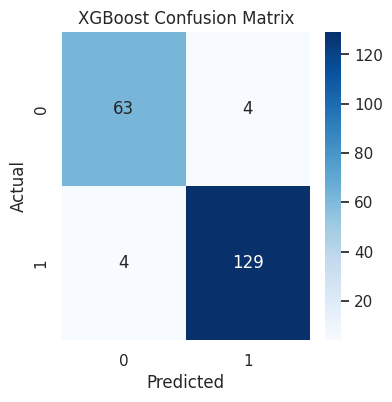

In [ ]:
results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    # Cross-validation accuracy
    cv_acc = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy').mean()

    # Train final model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred, multi_class='ovr')

    results[name] = [acc, auc, cv_acc]

    # Print results
    print(f"\n{name}:")
    print(f"Test Accuracy: {acc:.3f}")
    print(f"Cross-Val Accuracy: {cv_acc:.3f}")
    print(f"ROC AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix for the current model
    plt.figure(figsize=(4,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

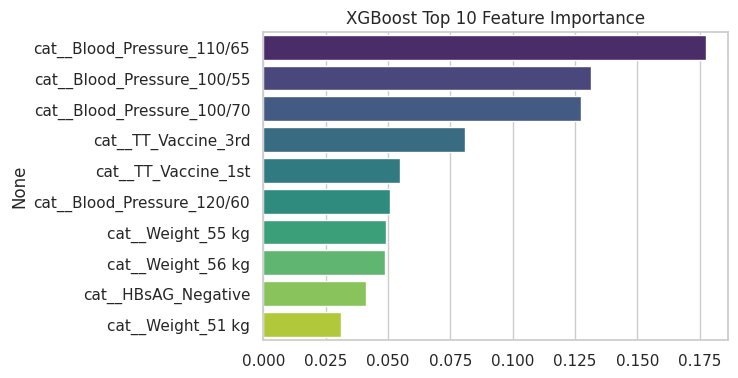

In [ ]:
if name in ['Random Forest', 'XGBoost']:
        # Access the classifier from the pipeline
        classifier = model.named_steps['classifier']
        # Get the feature names generated by the preprocessor
        feature_names = model.named_steps['preprocess'].get_feature_names_out()

        feat_imp = pd.Series(classifier.feature_importances_, index=feature_names).sort_values(ascending=False)[:10]
        plt.figure(figsize=(6,4))
        sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
        plt.title(f"{name} Top 10 Feature Importance")
        plt.show()

<Figure size 1000x400 with 0 Axes>

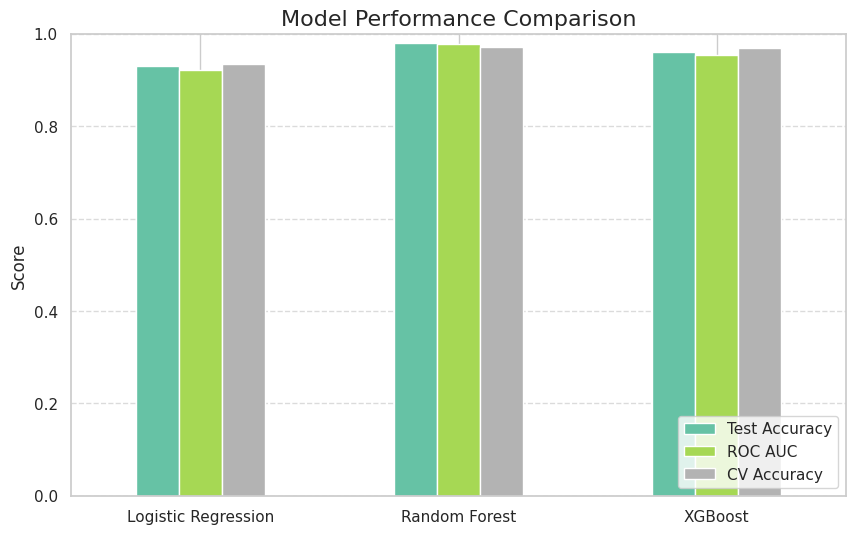

,Test Accuracy,ROC AUC,CV Accuracy
Logistic Regression,0.93,0.921445,0.934843
Random Forest,0.98,0.977556,0.972445
XGBoost,0.96,0.955112,0.968671


In [ ]:
results_df = pd.DataFrame(results, index=["Test Accuracy", "ROC AUC", "CV Accuracy"]).T

plt.figure(figsize=(10,4))
results_df.plot(kind='bar', figsize=(10,6), rot=0, colormap='Set2')
plt.title("Model Performance Comparison", fontsize=16)
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

display(results_df)


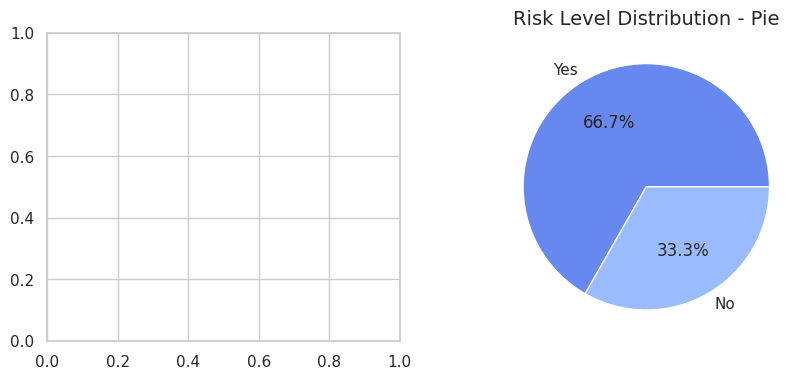

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
# Pie chart
df['Risk_Level'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('coolwarm'), ax=axes[1])
axes[1].set_title("Risk Level Distribution - Pie", fontsize=14)
axes[1].set_ylabel("")

plt.show()

In [ ]:
%%writefile app.py
import gradio as gr
import joblib
import numpy as np
import pandas as pd

# Load saved model + label encoder
model = joblib.load("model.joblib")
label_enc = joblib.load("label_encoder.joblib")

# Feature order (must match model training!)
feature_names = [
    "Age","Gravida","Gestational_Period","Weight","Height","Blood_Pressure",
    "Fetal_Heartbeat","TT_Vaccine","Anemia","Jaundice","Fetal_Position",
    "Fetal_Movement","Urine_Albumin","Urine_Sugar","VDRL","HBsAG"
]

care_dict = {
    0: "Low Risk: Regular check-ups.",
    1: "Medium Risk: Consult doctor soon.",
    2: "High Risk: Immediate medical care required!"
}

def predict_risk(*values):
    data = np.array(values).reshape(1, -1)
    pred = model.predict(data)[0]
    risk_text = care_dict[pred]
    return f"Predicted Risk: {pred}\n\nRecommendation: {risk_text}"

inputs = [gr.Number(label=f) for f in feature_names]
output = gr.Textbox(label="Prediction Result")

app = gr.Interface(fn=predict_risk, inputs=inputs, outputs=output, title="Maternal Health Risk Prediction")

app.launch()


Writing app.py
